# Denoising Diffusion Probabilistic Models with miniai

Now that we written our own barebones training library, let's make some progress towards exploring diffusion model and building Stable Diffusion from scratch.

We'll start with building and training the model described in the seminal 2020 paper [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) (DDPM). For more context, while diffusion models were technically invented [back in 2015](https://arxiv.org/abs/1503.03585), diffusion models flew under the radar until this 2020 paper since they were complicated and difficult to train. The 2020 paper introducing DDPMs made some crucial assumptions that significantly simplify the model training and generation processes, as we will see here. Later versions of diffusion models all build upon the same framework introduced in this paper.

Let's get started and train our own DDPM!

[youtube video](https://www.youtube.com/watch?v=ItyO8s48zdc)

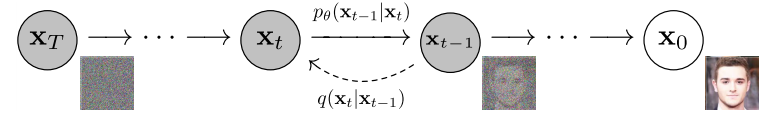

- $X_T$ is the pure noise image
- $X_0$ is the clean generated image
- forward process is the process where noise is **added** to a clean image - distributions $q(x_t | x_{x-1})$
- reverse process is the process where noise is cleaned up into a good looking image - distributions $p(x_{t-1} | x_{x})$

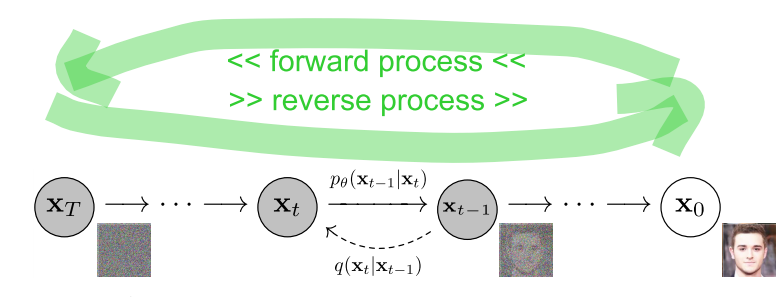

- forward process is the process where noise is **added** to a clean image - distributions $q(x_t | x_{x-1})$

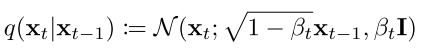

The parameter $\beta$ defines the amount of noise, and the amount of noise increases with $T$.

Therefore $\beta_t > \beta_{t-1}$

Interpret the formula $\large \mathcal{N}(x_t; \sqrt{1-\beta_t} \times x_{t-1}, \beta_t \times I)$:
- Gaussian distribution describing $x_t$ (image)
- Mean is $\sqrt{1-\beta_t} \times x_{t-1}$
    - The distribution mean is the previous image multiplied by a factor $\sqrt{1-\beta_t}$
    - The larger $\beta_t$, the smaller the factor. Meaning that the image tends to a mean of 0 when t is close to T
- Covariance Matrix is $\beta_t \times I$
    - The distribution variance is a diagonal matrix with value $\beta_t$
    - The closer to T we are, the larger the variance is (amount of noise)
    
Extreme cases:
- $q(x_1 | x_0)$ = $\mathcal{N}(x_1; \sqrt{1-\beta_1} \times x_0, \beta_1 \times I)$
- $1-\beta_1$ is very close to 1
- meaning that $x_1$'s mean is very close to the original image, and the variance is small

Thanks to these assumptions and the "recursive" character of the forward process, we can calculate $q(x_t|x_0)$ in close form:

$\large q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha_t} \times x_0}, (1-\bar{\alpha_t}) \times I)$

where:
- $\large \alpha_t = 1 - \beta_t$
- $\large \bar{\alpha_t} = \prod^t_{s=1}{\alpha_s}$. And therefore ($\bar{\alpha_t} < \bar{\alpha_{t-1}}$)
- $x_0$ is our clean image

- reverse process is the process where noise is cleaned up - distributions $p(x_{t-1} | x_{x})$

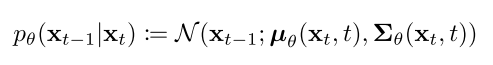

- We will use a neural network to evaluate $\mu_\theta(x_t, t)$ 
- We will disregard the variance term and use a constant dependent on $\beta_t$ instead

And after calculation and simplification, we can use the following optimization objective, which is actually a MSE function:

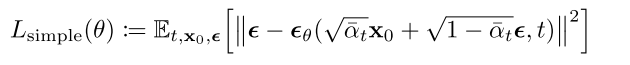

- It turns out that the expression within $\epsilon_\theta(...)$ is $x_t$. 
- And $\epsilon_\theta(...)$ is a noise estimator, which we compare in the loss function with the real noise (MSE between the two noises)

## Imports

We'll start with some imports.

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

Using cuda


In [ ]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

We will load the dataset from HuggingFace Hub:

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

To make life simpler (mostly with the model architecture), we'll resize the 28x28 images to 32x32:

In [ ]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

Let's set our batch size and create our DataLoaders with this batch size. we can confirm the shapes are correct. Note that while we do get the labels for the dataset, we actuallydon't care about that for our task of **unconditional** image generation.

In [ ]:
set_seed(42)
# bs = 128 # 128 is too large for the laptop GPU RAM
bs = 96
# bs = 64  # 64 is too small and model oscilates and does not train well
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([96, 1, 32, 32]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [ ]:
dt = dls.train
xb, yb = next(iter(dt))

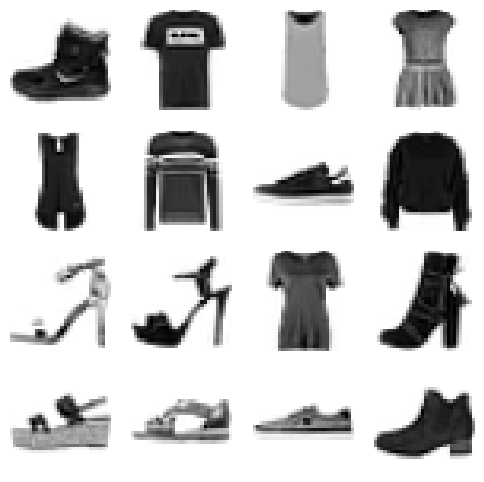

In [ ]:
show_images(xb[:16], imsize=1.5)

## Create model

We will create a U-net. U-net takes in a noisy image and predict the noise as output

A U-net looks something like this:

<img src="https://huggingface.co/blog/assets/78_annotated-diffusion/unet_architecture.jpg" width="700">

The DDPM U-net is a modification of this with some modern tricks like using attention.

We will cover how U-nets are created and how modules like attention work in future lessons. For now, we'll import the U-net from the diffusers library:

In [ ]:
from diffusers import UNet2DModel

In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

## Training - easy with a callback!

DDPM is trained quite simply in a few steps:
1. randomly select some timesteps in an iterative noising process.
2. Add noise corresponding to this timestep to the original image. For increasing timesteps, the variance of the noise increases.
3. Pass in this noisy image and the timestep to our model
4. Model is trained with an MSE loss between the model output and the amount of noise added to the image


We will implement this in a callback. The callback will randomly select the timestep and create the noisy image before setting up our input and ground truth tensors for the model forward pass and loss calculation.

After training, we need to sample from this model. This is an iterative denoising process starting from pure noise. We simply keep removing noise predicted by the neural network, but we do it with an expected noise schedule that is reverse of what we saw during training. This is also done in our callback.

In [ ]:
n_steps,βmin,βmax = 1000, 0.0001, 0.02
β = torch.linspace(βmin, βmax, n_steps)
α = 1. - β
ᾱ = α.cumprod(dim=0)
σ = β.sqrt()

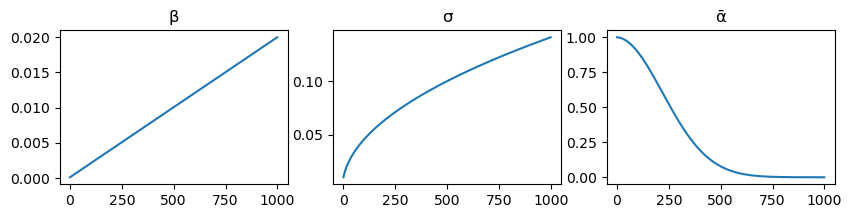

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
ax1.plot(β)
ax1.set_title('β')
ax2.plot(σ)
ax2.set_title('σ')
ax3.plot(ᾱ)
ax3.set_title('ᾱ')

plt.show();

In [ ]:
class DDPMCB(TrainCB):
    order = DeviceCB.order + 1
    def __init__(self, n_steps, beta_min, beta_max):
        # added super().__init__ to ensure that n_inp is created within this callback
        super().__init__()
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): 
        """Change the way the model will evaluate prediction (miniai feature)"""
        # Need to unpack the batch because bastch inclused image AND timestep -> *learn.batch[0]
        # Huggingface has its own API, to get a prediction, need to apply .sample to the model
        learn.preds = learn.model(*learn.batch[0]).sample
    
    def before_batch(self, learn):
        # model takes the noisy image and the timestep
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # actual noise and also the target to predict, x_T
        x0 = learn.batch[0] # original images, x_0, to which we need to add the appropriate noise
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt =  ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε # noisify the original image into noisy image at timestep t
        # input to our model is noisy image and timestep, ground truth is the noise 
        learn.batch = ((xt, t), ε)  # Pass the noisy image, the time step and the noise target to the model
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            # x_0_hat is the prediction where we completely remove the noise
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            # then we take weighted average of the noisy image (x_t) and the denoised image (x_0) to keep some noise 
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            # evaluate the weighted average
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

Okay now we're ready to train a model!

Let's create our `Learner`. We'll add our callbacks and train with MSE loss.

We specify the number of timesteps and the minimum and maximum variance for the DDPM model.

Code below is same as for augment nb, with the additional DDPMCB callback

In [ ]:
lr = 4e-3    # after 1200 batches, MSE loss climb back to 1. Seems the default eps in Adams is too small
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
opt_func = partial(optim.Adam, eps=1e-5)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

> Important note:
>
> When using default Adam, MSE loss climb back above  1 after 1200 batches. This is because at a certain point, the value used to divide in the exponential averaging is too small, which is equivalent to jacking up the lr. Adam'sdefault `eps` used to avoid this phenomenon is still too small (1e-9). To prevent this, we use a smaller `eps` of 1e-5

Now let's run the fit function:

loss,epoch,train
0.050,0,train
0.023,0,eval
0.021,1,train
0.020,1,eval
0.018,2,train
0.018,2,eval
0.016,3,train
0.016,3,eval
0.015,4,train
0.016,4,eval


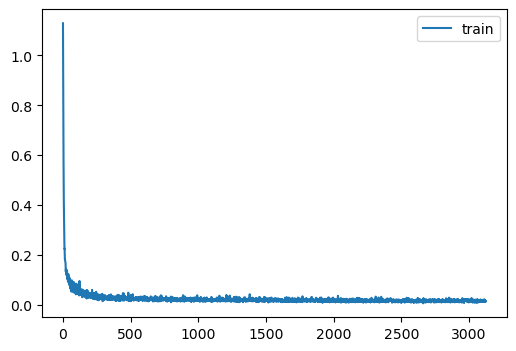

In [ ]:
learn.fit(epochs)

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [ ]:
# torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [ ]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

## Inference

[In YT video here](https://youtu.be/ItyO8s48zdc?t=3785)

Now that we've trained our model, let's generate some images with our model:

In [ ]:
set_seed(42)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

1000

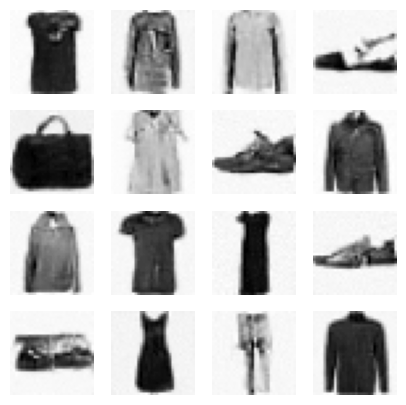

In [ ]:
show_images(samples[-1], figsize=(5,5));

Let's visualize the sampling process:

In [ ]:
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML


def _show_i(i): 
    return show_image(-samples[i][9], ax=ax, animated=True).get_images()

fig,ax = plt.subplots(figsize=(3,3))
r = L.range(800,990, 5) + L.range(990,1000) + [999] * 10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
# display(HTML(animate.to_html5_video()))

Using matplotlib backend: agg


Note that I only take the steps between 800 and 1000 since most of the previous steps are actually quite noisy. This is a limitation of the noise schedule used for small images, and papers like [Improved DDPM](https://arxiv.org/abs/2102.09672) suggest other noise schedules for this purpose! (Some potential homework: try out the noise schedule from Improved DDPM and see if it helps.)